# Model Explanations: Real vs. Synthetic Data

This notebook implements a rigorous, step-by-step process to compare the explanation stability of models trained on real data versus models trained on synthetically augmented data.

**Core Metric:** Explanation Stability Score (ESS), which measures how robust a model's explanations are to small perturbations in the input data.

## Ground Rule: Define the Explanation Space

🎯 **All explanations are generated in the preprocessed (normalized) feature space.**

This is a critical decision to ensure a fair and technically correct comparison.

**Why?**
- **Avoids Pipeline Mismatch:** Both the real and synthetic models receive data in the exact same format.
- **Removes Feature Ambiguity:** There is no confusion between raw clinical values and their scaled/encoded counterparts.
- **Enables Fair Comparison:** We are comparing the models' responses to the same feature distribution, isolating the impact of the training data (real vs. synthetic).

## STEP 1️⃣: Setup and Imports

In [50]:
import sys
import random
import json
from pathlib import Path
from typing import Callable, Dict, List, Tuple

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# SHAP and LIME for explanations
import shap
from lime.lime_tabular import LimeTabularExplainer

# Optional: xgboost import (models can still be joblib-loaded without this in many cases)
try:
    import xgboost  # noqa: F401
except Exception:
    xgboost = None

# Scipy for stability metric calculation
from scipy.stats import spearmanr

# Scikit-learn components
from sklearn.pipeline import Pipeline

# --- Configuration ---
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# --- Paths ---
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / 'data'
MODELS_DIR = PROJECT_ROOT / 'models'
RESULTS_DIR = PROJECT_ROOT / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

# --- Plotting Style ---
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print(f"✅ Setup complete. Using project root: {PROJECT_ROOT}")
print(f"SHAP version: {shap.__version__}")

✅ Setup complete. Using project root: e:\docs\FYP\demo\CKD_Risk_Prediction
SHAP version: 0.49.1


## STEP 2️⃣: Load Preprocessing Artifacts & Data

🚫 **Do not refit anything.**

We load the pre-fitted preprocessing objects and the already transformed data. This ensures we use the exact same feature space that the models were trained on.

In [45]:
# --- Load Feature Names ---
# These are the names of the columns *after* preprocessing.
FEATURE_NAMES_PATH = DATA_DIR / 'processed' / 'preprocessed' / 'feature_names.json'
with open(FEATURE_NAMES_PATH, 'r') as f:
    feature_names = json.load(f)

# --- Load Preprocessed Data ---
# This data has already been scaled and encoded.
X_train_preprocessed = pd.read_csv(DATA_DIR / 'processed' / 'preprocessed' / 'X_train_preproc.csv')
X_test_preprocessed = pd.read_csv(DATA_DIR / 'processed' / 'preprocessed' / 'X_test_preproc.csv')
y_test = pd.read_csv(DATA_DIR / 'processed' / 'splits' / 'y_test.csv').iloc[:, 0]

# Ensure column names are consistent
X_train_preprocessed.columns = feature_names
X_test_preprocessed.columns = feature_names


print("✅ Preprocessing artifacts and data loaded.")
print(f"   Number of features: {len(feature_names)}")
print(f"   Train data shape: {X_train_preprocessed.shape}")
print(f"   Test data shape:  {X_test_preprocessed.shape}")

✅ Preprocessing artifacts and data loaded.
   Number of features: 34
   Train data shape: (280, 34)
   Test data shape:  (120, 34)


## STEP 3️⃣: Load Both Models Consistently

We load two models for comparison:
1.  **Real Model**: A scikit-learn `Pipeline` that includes preprocessing and the final estimator, trained only on real data.
2.  **Augmented Model**: The final estimator *only*, trained on a mix of real and synthetic data.

In [51]:
# We support explaining LR / RF / XGB for both real-only and augmented models.
# Set MODELS_TO_RUN to any subset of: ['lr', 'rf', 'xgb']
MODELS_TO_RUN = ['lr', 'rf', 'xgb']  # or e.g. ['lr']
REPORT_MODEL_KEY = MODELS_TO_RUN[0]  # which model to use for the single-model plots/tables below
MODEL_SPECS = {
    'lr': {
        'real': 'lr.joblib',
        'augmented': 'lr_augmented_42.joblib',
        'pretty': 'Logistic Regression',
    },
    'rf': {
        'real': 'rf.joblib',
        'augmented': 'rf_augmented_42.joblib',
        'pretty': 'Random Forest',
    },
    'xgb': {
        'real': 'xgb.joblib',
        'augmented': 'xgb_augmented_42.joblib',
        'pretty': 'XGBoost',
    },
}

def _get_pipeline_preprocessor(pipeline: Pipeline):
    return pipeline.named_steps.get('preprocess') or pipeline.named_steps.get('preprocessor')


def get_real_feature_names_clean(real_pipeline: Pipeline) -> List[str]:
    """Return the post-preprocessing feature names (cleaned) used by the real pipeline estimator."""
    preprocessor = _get_pipeline_preprocessor(real_pipeline)
    if preprocessor is not None:
        names = list(preprocessor.get_feature_names_out())
    else:
        # Safe fallback based on your earlier pipeline outputs
        names = ['hemo', 'sc', 'al', 'age', 'htn_0.0', 'htn_1.0', 'dm_0.0', 'dm_1.0']
    # Strip sklearn prefixes like 'num__' / 'cat__'
    return [str(n).split('__')[-1] for n in names]


models: Dict[str, Dict[str, object]] = {}
for key in MODELS_TO_RUN:
    spec = MODEL_SPECS[key]
    real_pipeline = joblib.load(MODELS_DIR / spec['real'])
    real_estimator = real_pipeline.named_steps.get('model') or real_pipeline.named_steps.get('clf') or real_pipeline.steps[-1][1]
    augmented_estimator = joblib.load(MODELS_DIR / spec['augmented'])
    models[key] = {
        'real_pipeline': real_pipeline,
        'real_estimator': real_estimator,
        'augmented_estimator': augmented_estimator,
        'pretty': spec['pretty'],
    }

print("✅ Models loaded successfully:")
for k in MODELS_TO_RUN:
    print(f"  - {k}: real={type(models[k]['real_estimator']).__name__}, augmented={type(models[k]['augmented_estimator']).__name__}")

✅ Models loaded successfully:
  - lr: real=LogisticRegression, augmented=LogisticRegression
  - rf: real=RandomForestClassifier, augmented=RandomForestClassifier
  - xgb: real=XGBClassifier, augmented=XGBClassifier


## STEP 4️⃣: Create a Unified Prediction Interface

📌 **Both models must behave as: `f(x_preprocessed) -> P(CKD)`**

This is crucial for LIME, which requires a function that accepts a numpy array and returns prediction probabilities.

In [53]:
# Unified prediction helpers for LIME/ESS.
# We operate in preprocessed feature space (already scaled/encoded).

# The augmented models were trained on these 6 preprocessed columns:
FEAT_6_AUGMENTED = ['hemo', 'sc', 'al', 'age', 'htn_1.0', 'dm_1.0']


def make_predict_fn(estimator, columns: List[str]) -> Callable[[np.ndarray], np.ndarray]:
    """Return predict_proba(x_np) for an estimator expecting the given columns."""
    def _predict(x_np: np.ndarray) -> np.ndarray:
        x_df = pd.DataFrame(x_np, columns=columns)
        return estimator.predict_proba(x_df)
    return _predict


def get_real_columns_for_model(model_key: str) -> List[str]:
    return get_real_feature_names_clean(models[model_key]['real_pipeline'])


print("✅ Prediction helpers created.")
print(f"   Augmented feature set (6): {FEAT_6_AUGMENTED}")
print(f"   Example real feature set ({REPORT_MODEL_KEY}): {get_real_columns_for_model(REPORT_MODEL_KEY)}")

✅ Prediction helpers created.
   Augmented feature set (6): ['hemo', 'sc', 'al', 'age', 'htn_1.0', 'dm_1.0']
   Example real feature set (lr): ['hemo', 'sc', 'al', 'age', 'htn_0.0', 'htn_1.0', 'dm_0.0', 'dm_1.0']


## STEP 5️⃣: Prepare Background Data (SHAP/LIME)

We use the **SAME background data** for both models.

**Why?**
- **Removes Bias:** Ensures the baseline for explanations is identical.
- **Isolates Model Effect:** Any difference in explanations is due to the models themselves, not the data distribution they are being explained against.

In [52]:
# Sample 100 data points from the preprocessed training set
# This serves as the background distribution for SHAP and LIME
background_data = X_train_preprocessed.sample(100, random_state=RANDOM_SEED)

print(f"✅ Background data created with shape: {background_data.shape}")

✅ Background data created with shape: (100, 34)


## STEP 6️⃣: SHAP Explanation Implementation

📌 **We are now comparing explanations in the same preprocessed space.**

We use `shap.LinearExplainer` because our example model is Logistic Regression. This provides exact SHAP values without approximation.

✅ SHAP computed for Logistic Regression: real(8), augmented(6)
✅ SHAP computed for Random Forest: real(8), augmented(6)


ExactExplainer explainer: 2it [00:13, 13.75s/it]               


✅ SHAP computed for XGBoost: real(8), augmented(6)

--- SHAP Waterfall Plots (Report Model: Logistic Regression) ---


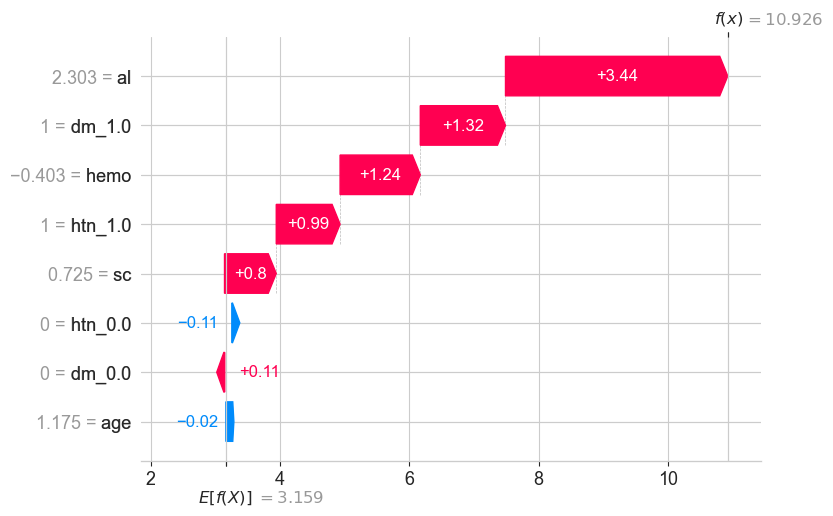

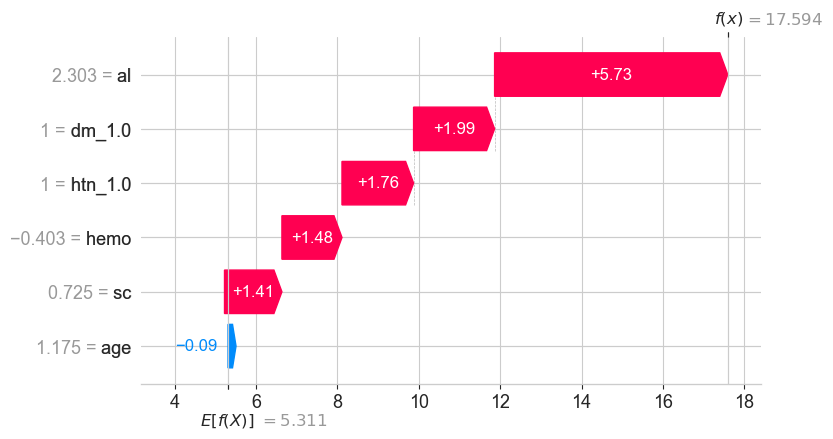

In [55]:
# --- SHAP for LR / RF / XGB ---
instance_index = 0
x_instance_full = X_test_preprocessed.iloc[[instance_index]]

def _is_xgb_model(estimator) -> bool:
    name = type(estimator).__name__.lower()
    return 'xgb' in name or hasattr(estimator, 'get_booster')


def _is_tree_model(estimator) -> bool:
    name = type(estimator).__name__.lower()
    return (
        'randomforest' in name
        or (('xgb' in name) and not _is_xgb_model(estimator) is False)  # keep legacy check
        or hasattr(estimator, 'estimators_')
    )


def _make_shap_explainer(estimator, background_df: pd.DataFrame):
    """Create a SHAP explainer compatible with LR/RF/XGB estimators."""
    # Linear models (e.g., LogisticRegression)
    if hasattr(estimator, 'coef_') and not _is_xgb_model(estimator):
        return shap.LinearExplainer(estimator, background_df)

    # XGBoost workaround: SHAP TreeExplainer can fail with some XGBoost 3.x model metadata (base_score string).
    # Use model-agnostic SHAP on predict_proba instead (slower but robust for single-instance explanations).
    if _is_xgb_model(estimator):
        masker = shap.maskers.Independent(background_df)
        return shap.Explainer(estimator.predict_proba, masker)

    # Tree-based sklearn models (RF, etc.)
    if _is_tree_model(estimator):
        return shap.TreeExplainer(estimator, data=background_df, model_output='probability')

    # Fallback: model-agnostic
    masker = shap.maskers.Independent(background_df)
    return shap.Explainer(estimator.predict_proba, masker)


def _select_positive_class(expl: 'shap.Explanation', class_index: int = 1) -> 'shap.Explanation':
    """If SHAP values include class dimension, slice to the positive class."""
    try:
        values = np.asarray(expl.values)
        if values.ndim == 3 and values.shape[-1] > class_index:
            return expl[..., class_index]
    except Exception:
        pass
    return expl


shap_results = {}  # model_key -> {'real': Explanation, 'augmented': Explanation}
for key in MODELS_TO_RUN:
    pretty = models[key]['pretty']
    real_cols = get_real_columns_for_model(key)
    aug_cols = FEAT_6_AUGMENTED

    explainer_real = _make_shap_explainer(models[key]['real_estimator'], background_data[real_cols])
    explainer_aug = _make_shap_explainer(models[key]['augmented_estimator'], background_data[aug_cols])

    sv_real = explainer_real(x_instance_full[real_cols])
    sv_aug = explainer_aug(x_instance_full[aug_cols])
    shap_results[key] = {'real': sv_real, 'augmented': sv_aug, 'real_cols': real_cols, 'aug_cols': aug_cols}

    print(f"✅ SHAP computed for {pretty}: real({len(real_cols)}), augmented({len(aug_cols)})")

# --- Plot SHAP for the report model (keeps notebook output readable) ---
key = REPORT_MODEL_KEY
pretty = models[key]['pretty']
sv_real = _select_positive_class(shap_results[key]['real'])
sv_aug = _select_positive_class(shap_results[key]['augmented'])

print(f"\n--- SHAP Waterfall Plots (Report Model: {pretty}) ---")
shap.plots.waterfall(sv_real[0], max_display=12)
shap.plots.waterfall(sv_aug[0], max_display=12)

## STEP 7️⃣: LIME Explanation with Stability Control

To get stable LIME results, we:
1.  Initialize the explainer **ONCE** on the background data.
2.  Run the explanation **multiple times** (e.g., 20) with different random seeds.
3.  Aggregate the results.

In [56]:
# --- LIME utilities (shared across LR/RF/XGB) ---

def _exp_to_feature_weight_dict(exp, columns: List[str], label: int = 1) -> dict:
    """Robustly convert a LIME Explanation to {feature_name: weight}.
    Prefer `as_map()` (stable feature indices) over `as_list()` (rule strings).
    """
    try:
        amap = exp.as_map()
        pairs = amap.get(label, None)
        if pairs is None and len(amap) == 1:
            pairs = next(iter(amap.values()))

        out = {}
        if pairs:
            for fid, weight in pairs:
                if 0 <= int(fid) < len(columns):
                    out[str(columns[int(fid)])] = float(weight)
                else:
                    out[str(fid)] = float(weight)
        if out:
            return out
    except Exception:
        pass

    # Fallback: use rule strings
    try:
        return {str(k): float(v) for k, v in exp.as_list(label=label)}
    except Exception:
        return {}


def run_lime_multiple(
    lime_explainer: LimeTabularExplainer,
    predict_fn: Callable[[np.ndarray], np.ndarray],
    x_instance_df: pd.DataFrame,
    runs: int = 20,
    label: int = 1,
) -> pd.DataFrame:
    """Runs LIME multiple times and returns a DataFrame of feature weights per run."""
    x_instance_np = x_instance_df.values.ravel()
    columns = [str(c) for c in x_instance_df.columns.tolist()]

    all_weights = []
    for i in range(runs):
        np.random.seed(RANDOM_SEED + i)

        exp = lime_explainer.explain_instance(
            x_instance_np,
            predict_fn,
            num_features=len(columns),
            labels=(label,),
        )

        weights_dict = _exp_to_feature_weight_dict(exp, columns=columns, label=label)
        all_weights.append(weights_dict)

    return pd.DataFrame(all_weights).fillna(0.0)


def make_lime_explainer(training_df: pd.DataFrame, feature_names: List[str]) -> LimeTabularExplainer:
    return LimeTabularExplainer(
        training_data=training_df.values,
        feature_names=feature_names,
        class_names=["No CKD", "CKD"],
        mode="classification",
        random_state=RANDOM_SEED,
    )


print("✅ LIME utilities defined.")

✅ LIME utilities defined.


## STEP 8️⃣: Aggregate LIME Explanations & Compute ESS (CORE METRIC)

The **Explanation Stability Score (ESS)** is the core metric for this analysis. It measures how much an explanation changes when the input is slightly perturbed. A higher score means a more stable, reliable explanation.

**ESS Calculation:**
1.  Get the mean feature importance ranks for the original instance.
2.  Get the mean feature importance ranks for a slightly perturbed instance.
3.  Calculate the **Spearman rank correlation** between these two sets of ranks.

In [57]:
def perturb_instance(x_instance_df: pd.DataFrame, sigma: float = 0.01) -> pd.DataFrame:
    """Adds small Gaussian noise to a preprocessed instance."""
    noise = np.random.normal(0, sigma, size=x_instance_df.shape)
    return x_instance_df + noise


def compute_ess(
    lime_explainer: LimeTabularExplainer,
    predict_fn: Callable[[np.ndarray], np.ndarray],
    x_instance_df: pd.DataFrame,
    runs: int = 20,
    label: int = 1,
) -> Tuple[float, pd.Series]:
    """Computes ESS via Spearman rank correlation of mean LIME ranks (orig vs perturbed)."""
    lime_orig_df = run_lime_multiple(lime_explainer, predict_fn, x_instance_df, runs=runs, label=label)
    mean_rank_orig = lime_orig_df.mean().rank(ascending=False)

    x_perturbed = perturb_instance(x_instance_df)
    lime_pert_df = run_lime_multiple(lime_explainer, predict_fn, x_perturbed, runs=runs, label=label)
    mean_rank_pert = lime_pert_df.mean().rank(ascending=False)

    common_features = mean_rank_orig.index.intersection(mean_rank_pert.index)
    rank_corr, _ = spearmanr(mean_rank_orig[common_features], mean_rank_pert[common_features])

    mean_weights = lime_orig_df.mean().sort_values(ascending=False)
    return float(rank_corr), mean_weights


# --- Select instance (keep this cell runnable independently) ---
instance_index = 0
x_instance_full = X_test_preprocessed.iloc[[instance_index]]

# --- Compute ESS for each model (LR/RF/XGB) ---
ESS_RUNS = 20
ess_by_model = {}   # model_key -> {'real': float, 'augmented': float}
lime_weights_by_model = {}  # model_key -> {'real': Series, 'augmented': Series}

for key in MODELS_TO_RUN:
    pretty = models[key]['pretty']
    real_cols = get_real_columns_for_model(key)
    aug_cols = FEAT_6_AUGMENTED

    x_instance_real = x_instance_full[real_cols]
    x_instance_aug = x_instance_full[aug_cols]

    predict_real = make_predict_fn(models[key]['real_estimator'], real_cols)
    predict_aug = make_predict_fn(models[key]['augmented_estimator'], aug_cols)

    lime_explainer_real = make_lime_explainer(background_data[real_cols], real_cols)
    lime_explainer_aug = make_lime_explainer(background_data[aug_cols], aug_cols)

    print(f"Computing ESS for {pretty}...")
    ess_real, lime_weights_real = compute_ess(lime_explainer_real, predict_real, x_instance_real, runs=ESS_RUNS)
    ess_aug, lime_weights_aug = compute_ess(lime_explainer_aug, predict_aug, x_instance_aug, runs=ESS_RUNS)

    ess_by_model[key] = {'real': ess_real, 'augmented': ess_aug}
    lime_weights_by_model[key] = {'real': lime_weights_real, 'augmented': lime_weights_aug}

print("\n--- Explanation Stability Scores (ESS) ---")
for key in MODELS_TO_RUN:
    pretty = models[key]['pretty']
    print(f"{pretty:<18} | Real: {ess_by_model[key]['real']:.4f} | Augmented: {ess_by_model[key]['augmented']:.4f}")

# Backward-compatible variables (used by later cells) for REPORT_MODEL_KEY
ess_real = ess_by_model[REPORT_MODEL_KEY]['real']
ess_augmented = ess_by_model[REPORT_MODEL_KEY]['augmented']
lime_weights_real = lime_weights_by_model[REPORT_MODEL_KEY]['real']
lime_weights_augmented = lime_weights_by_model[REPORT_MODEL_KEY]['augmented']

Computing ESS for Logistic Regression...
Computing ESS for Random Forest...
Computing ESS for XGBoost...

--- Explanation Stability Scores (ESS) ---
Logistic Regression | Real: 0.8095 | Augmented: 0.7143
Random Forest      | Real: 0.4286 | Augmented: 0.0857
XGBoost            | Real: 0.8571 | Augmented: -0.0857


## STEP 9️⃣: Map Explanations Back to Clinical Meaning

To make our reports and plots understandable, we map the cryptic preprocessed feature names (e.g., `hemo_scaled`) back to their human-readable clinical names (e.g., "Hemoglobin").

In [58]:
# Clinical mapping for readability
raw_feature_names = [
 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
 'appet', 'pe', 'ane',
]

# Build map from preprocessed feature names -> clinical labels
clinical_map = {}
for preproc_name in feature_names:
    parts = str(preproc_name).split('_')
    base_name = parts[0]
    if base_name in {'htn', 'dm', 'cad', 'appet', 'ane', 'pe'} and len(parts) > 1:
        clinical_map[preproc_name] = f"{base_name.upper()}={parts[-1]}"
    elif base_name in raw_feature_names:
        clinical_map[preproc_name] = base_name.upper()
    else:
        clinical_map[preproc_name] = f"{base_name.upper()}={parts[-1]}"

# Manually improve some names for clarity
clinical_map['hemo'] = 'Hemoglobin'
clinical_map['bp'] = 'Blood Pressure'
clinical_map['bgr'] = 'Blood Glucose'
clinical_map['sc'] = 'Serum Creatinine'
clinical_map['age'] = 'Age'


def _lime_rule_to_feature(rule: str) -> str:
    """Extract base feature from LIME rule strings like 'age <= 0.5' or 'htn_1.0 > 0.0'."""
    s = str(rule).strip()
    for token in ['<=', '>=', '<', '>', '=']:
        if token in s:
            return s.split(token, 1)[0].strip()
    return s


def map_to_clinical(weights: pd.Series) -> pd.Series:
    """Map a weight Series (feature names or LIME rules) to clinical labels and aggregate duplicates."""
    weights = weights.copy()
    mapped_index = []
    for idx in weights.index:
        feat = _lime_rule_to_feature(idx)
        mapped_index.append(clinical_map.get(feat, feat))
    mapped = pd.Series(weights.values, index=mapped_index)
    return mapped.groupby(level=0).sum().sort_values(ascending=False)


lime_weights_real_clinical_by_model = {}
lime_weights_aug_clinical_by_model = {}
for key in MODELS_TO_RUN:
    lime_weights_real_clinical_by_model[key] = map_to_clinical(lime_weights_by_model[key]['real'])
    lime_weights_aug_clinical_by_model[key] = map_to_clinical(lime_weights_by_model[key]['augmented'])

print("✅ Clinical mapping created.")
print(f"\nExample Mapped LIME Weights (Report Model: {models[REPORT_MODEL_KEY]['pretty']} - Real):")
print(lime_weights_real_clinical_by_model[REPORT_MODEL_KEY].head())

# Backward-compatible variables for the report cell below
lime_weights_real_clinical = lime_weights_real_clinical_by_model[REPORT_MODEL_KEY]
lime_weights_augmented_clinical = lime_weights_aug_clinical_by_model[REPORT_MODEL_KEY]

✅ Clinical mapping created.

Example Mapped LIME Weights (Report Model: Logistic Regression - Real):
Hemoglobin          0.170521
Serum Creatinine    0.128850
AL                  0.128623
DM=1.0              0.121819
HTN=1.0             0.103002
dtype: float64


## STEP 🔟: Reporting (VERY IMPORTANT)

We do not just compare raw SHAP or LIME values. The most important comparison is the **Explanation Stability Score (ESS)**. We also visualize the feature importance ranks to see how they differ.

A higher ESS indicates a more trustworthy and reliable model explanation.

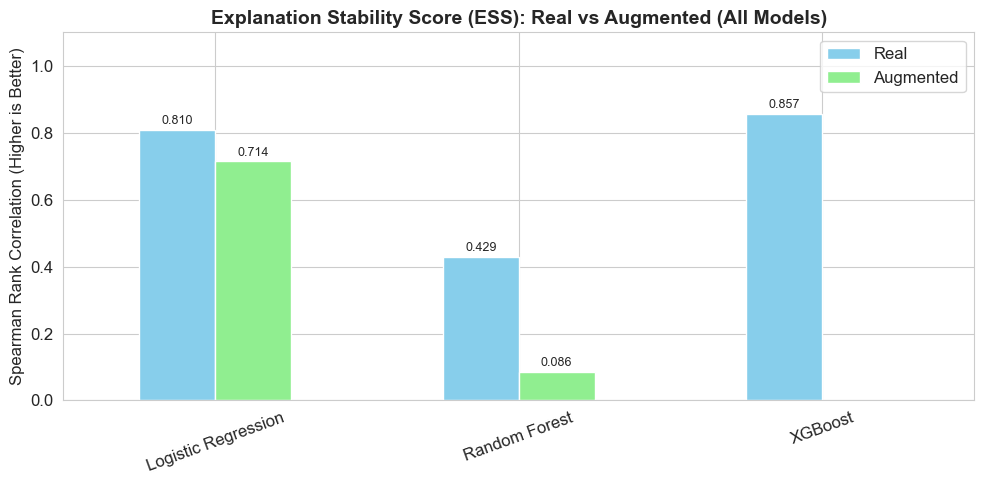

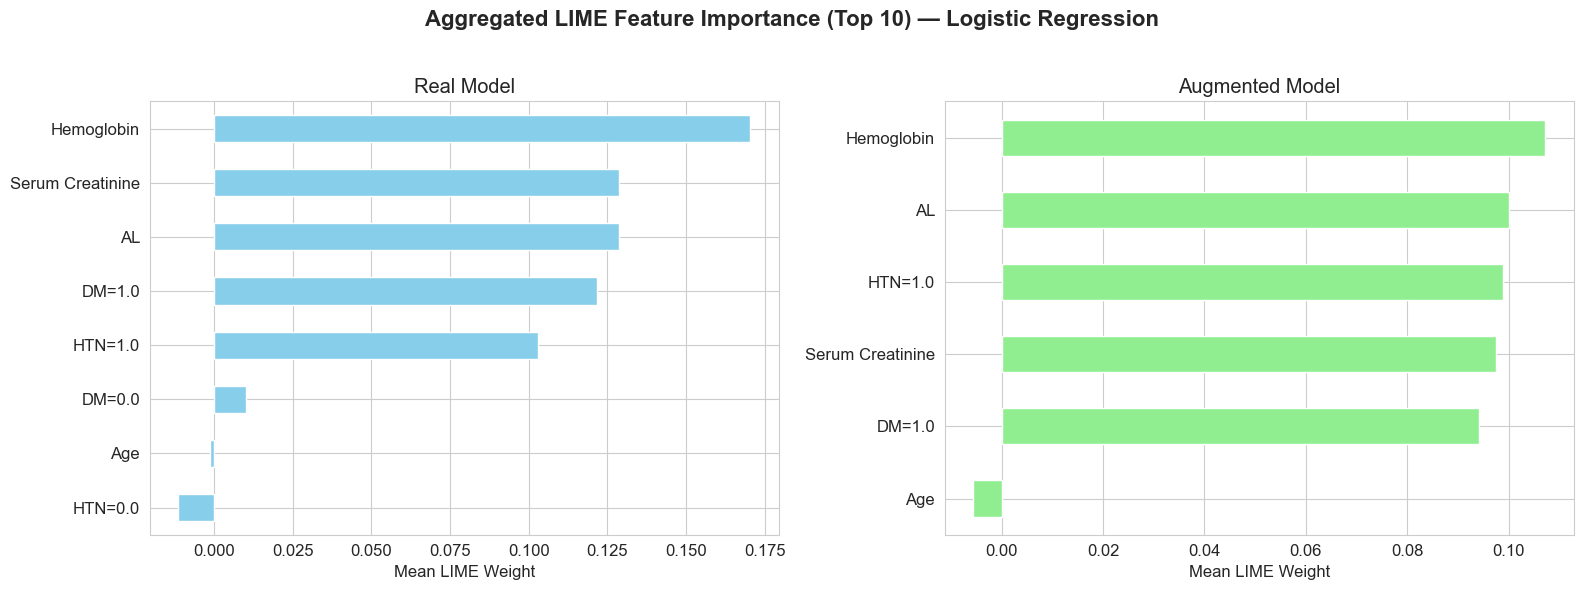


--- Feature Rank Consistency (Report model) ---
Mean absolute rank difference: 1.17

Top 5 features with largest rank change:
                  real_rank  augmented_rank  rank_diff
Serum Creatinine        2.0             4.0        2.0
HTN=1.0                 5.0             3.0        2.0
Age                     7.0             6.0        1.0
AL                      3.0             2.0        1.0
DM=1.0                  4.0             5.0        1.0

✅ Report saved to e:\docs\FYP\demo\CKD_Risk_Prediction\results\explanation_report.json


In [59]:
# --- 1. ESS Comparison across models (Real vs Augmented) ---
ess_table = pd.DataFrame({
    models[k]['pretty']: ess_by_model[k] for k in MODELS_TO_RUN
}).T
ess_table = ess_table.rename(columns={'real': 'Real', 'augmented': 'Augmented'})

ax = ess_table.plot(kind='bar', figsize=(10, 5), rot=20, color=['skyblue', 'lightgreen'])
plt.title('Explanation Stability Score (ESS): Real vs Augmented (All Models)', fontsize=14, fontweight='bold')
plt.ylabel('Spearman Rank Correlation (Higher is Better)')
plt.ylim(0, 1.1)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=2, fontsize=9)
plt.tight_layout()
plt.show()

# --- 2. Feature Importance Rank Consistency (Report model only, to keep output readable) ---
k = 10
top_k_real = lime_weights_real_clinical.head(k)
top_k_augmented = lime_weights_augmented_clinical.head(k)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
fig.suptitle(f"Aggregated LIME Feature Importance (Top 10) — {models[REPORT_MODEL_KEY]['pretty']}", fontsize=16, fontweight='bold')

top_k_real.sort_values().plot(kind='barh', ax=ax1, color='skyblue')
ax1.set_title('Real Model')
ax1.set_xlabel('Mean LIME Weight')

top_k_augmented.sort_values().plot(kind='barh', ax=ax2, color='lightgreen')
ax2.set_title('Augmented Model')
ax2.set_xlabel('Mean LIME Weight')

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

# --- 3. Rank Consistency Metric (Report model) ---
rank_df = pd.DataFrame({
    'real_rank': lime_weights_real_clinical.rank(ascending=False),
    'augmented_rank': lime_weights_augmented_clinical.rank(ascending=False)
}).dropna()
rank_df['rank_diff'] = (rank_df['real_rank'] - rank_df['augmented_rank']).abs()

print("\n--- Feature Rank Consistency (Report model) ---")
print(f"Mean absolute rank difference: {rank_df['rank_diff'].mean():.2f}")
print("\nTop 5 features with largest rank change:")
print(rank_df.sort_values('rank_diff', ascending=False).head())

# --- Save results (all models) ---
report = {
    'models_to_run': MODELS_TO_RUN,
    'report_model_key': REPORT_MODEL_KEY,
    'ess_by_model': ess_by_model,
    'mean_abs_rank_difference_report_model': float(rank_df['rank_diff'].mean()),
    'top_5_rank_changes_report_model': rank_df.sort_values('rank_diff', ascending=False).head().to_dict(),
}

with open(RESULTS_DIR / 'explanation_report.json', 'w') as f:
    json.dump(report, f, indent=4)

print(f"\n✅ Report saved to {RESULTS_DIR / 'explanation_report.json'}")

## STEP 1️⃣1️⃣: Plot All SHAP + LIME Explanations (All Models)

This section plots explanations for every model in `MODELS_TO_RUN` (Real vs Augmented).


All-model SHAP plots

=== Logistic Regression — SHAP Waterfall (Real) ===


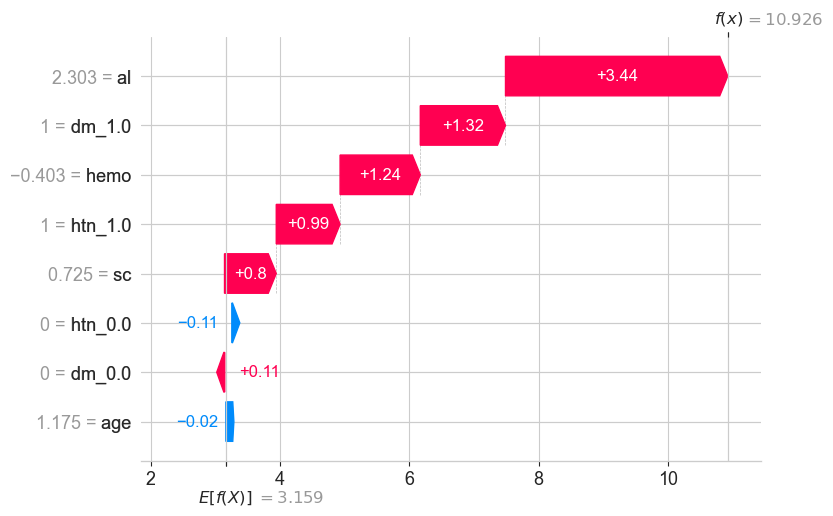


=== Logistic Regression — SHAP Waterfall (Augmented) ===


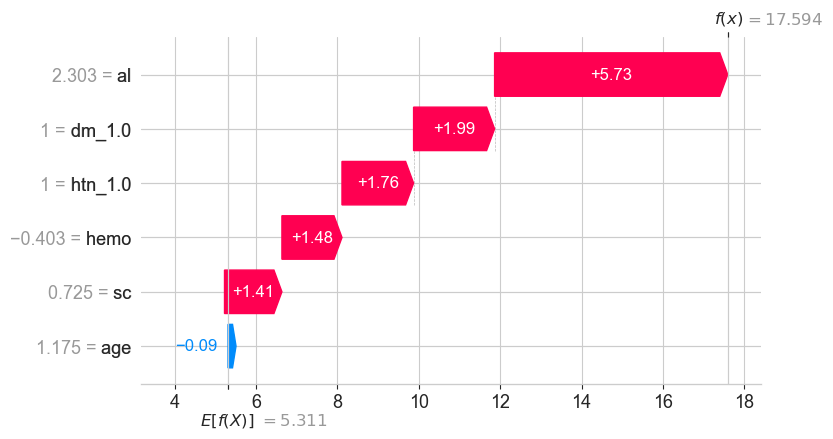


=== Random Forest — SHAP Waterfall (Real) ===


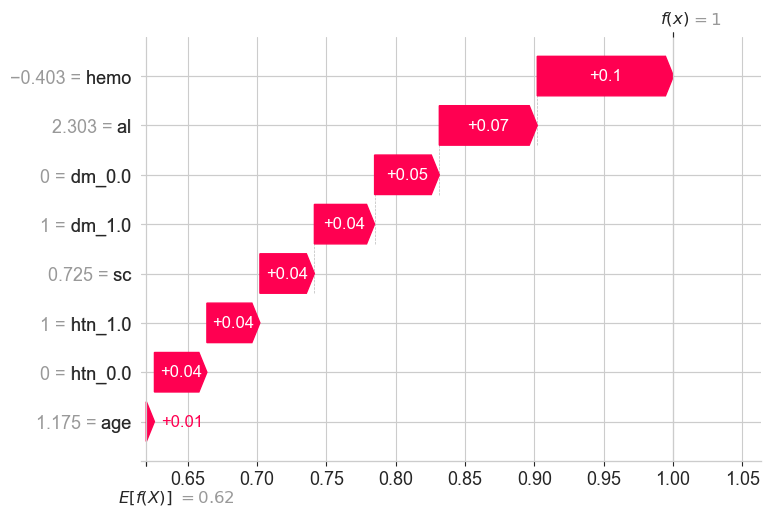


=== Random Forest — SHAP Waterfall (Augmented) ===


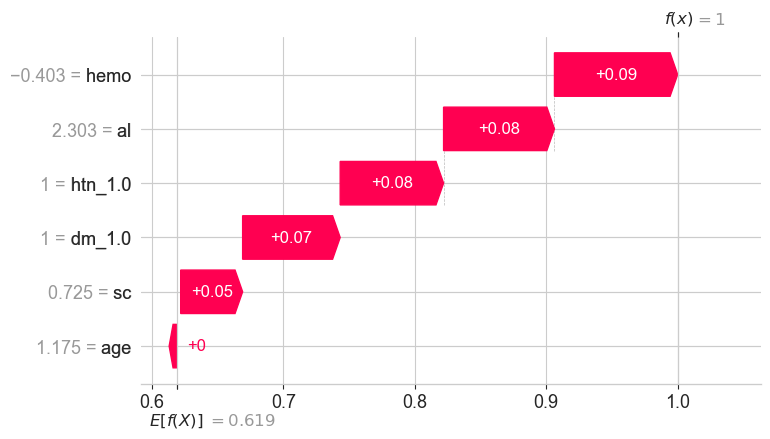


=== XGBoost — SHAP Waterfall (Real) ===


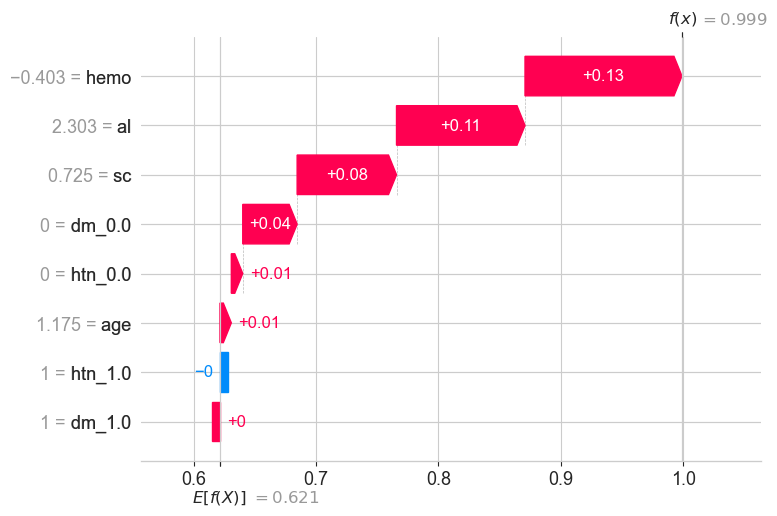


=== XGBoost — SHAP Waterfall (Augmented) ===


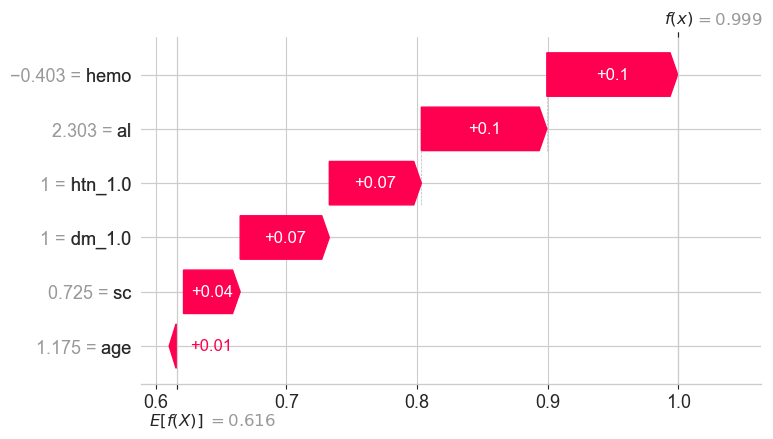


All-model LIME plots


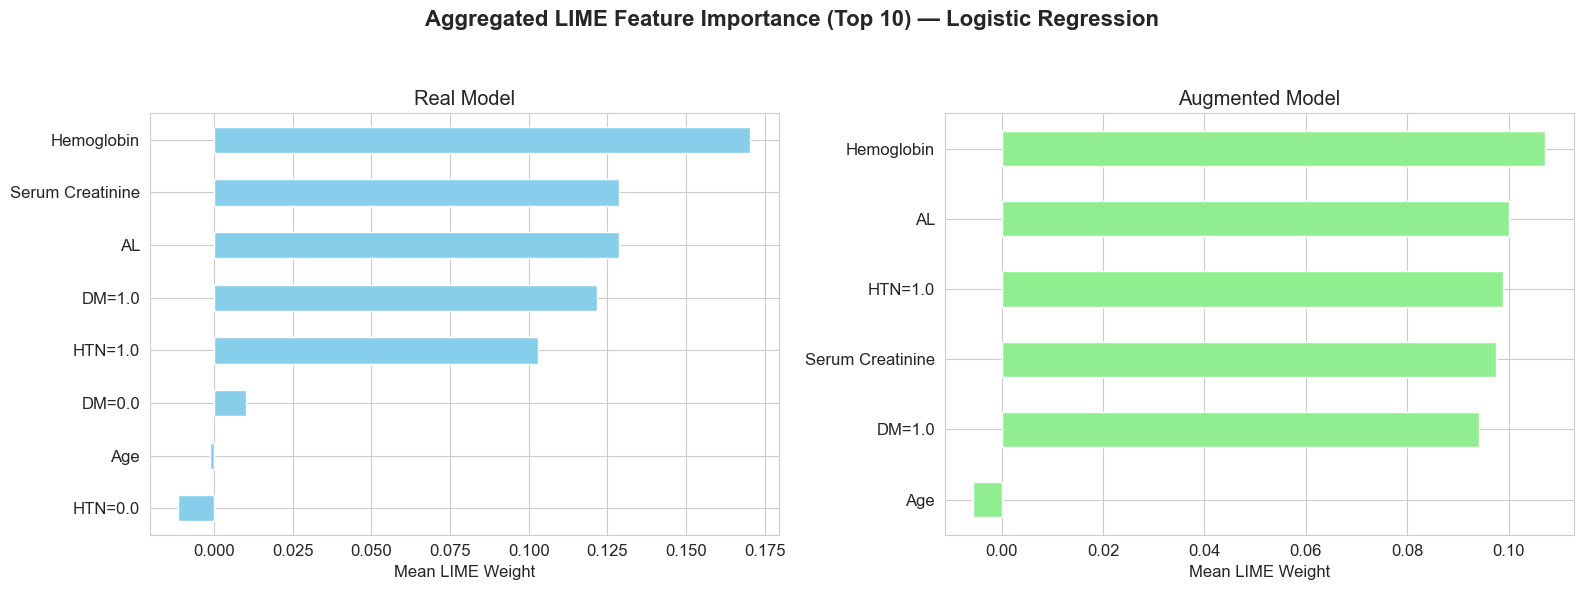

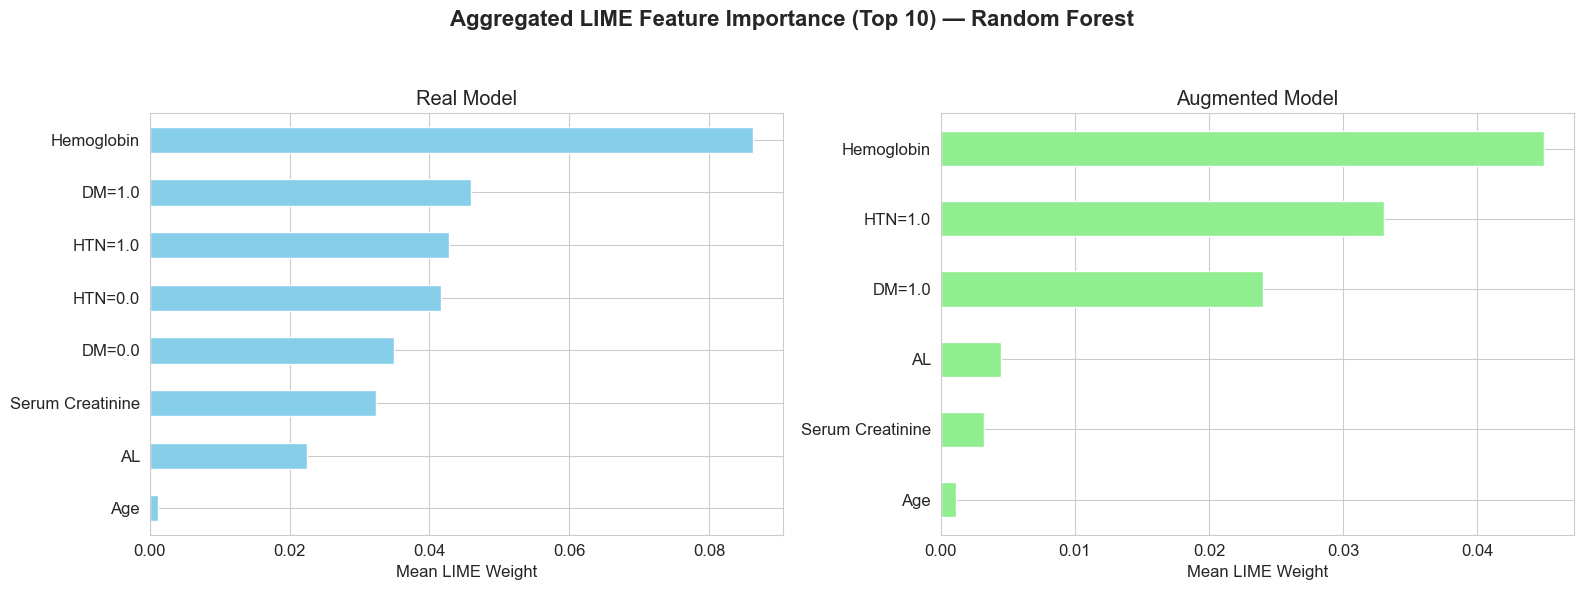

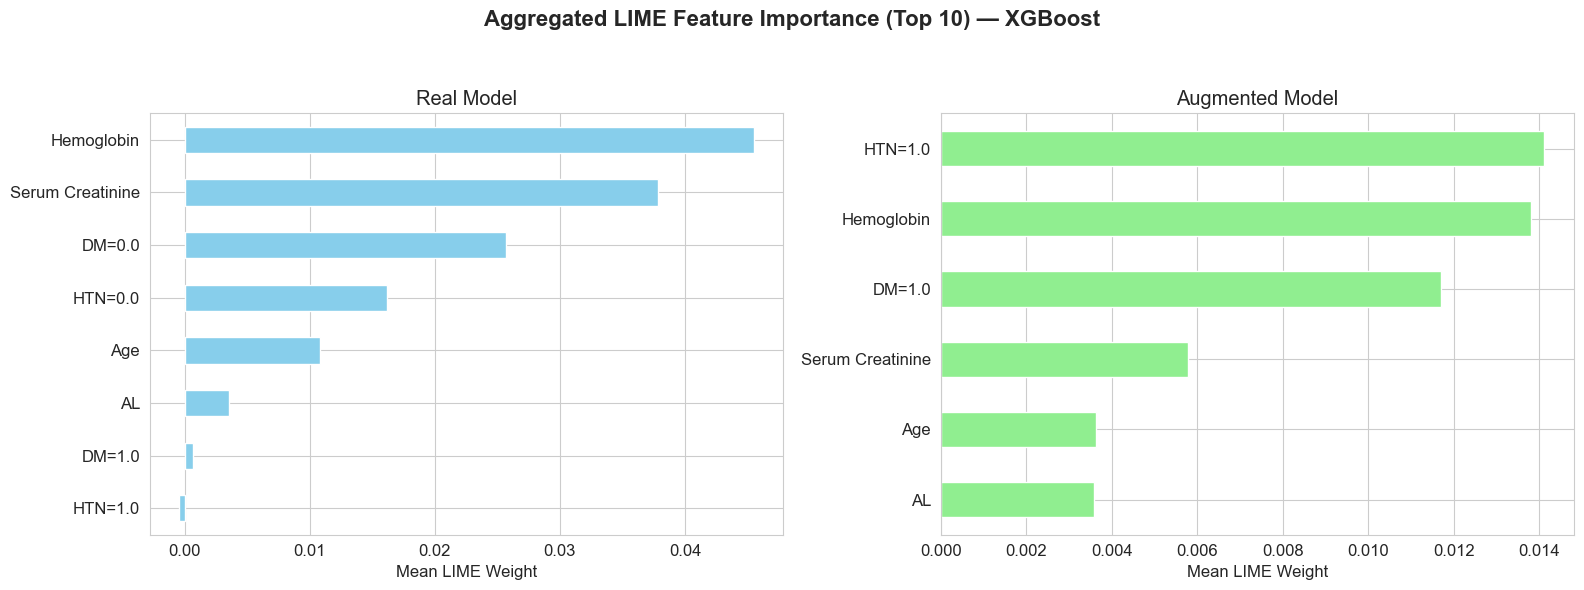

In [60]:
# Plot all SHAP + LIME explanations for every model in MODELS_TO_RUN.
# Notes:
# - SHAP: plots a per-instance waterfall for Real and Augmented.
# - LIME: plots aggregated (mean) feature weights (Top-k) for Real and Augmented.

PLOT_TOP_K = 10

# --- SHAP (all models) ---
if 'shap_results' not in globals():
    raise NameError("shap_results not found. Run STEP 6 (SHAP) first.")

print("\n====================")
print("All-model SHAP plots")
print("====================")
for key in MODELS_TO_RUN:
    pretty = models[key]['pretty']
    sv_real = _select_positive_class(shap_results[key]['real'])
    sv_aug = _select_positive_class(shap_results[key]['augmented'])

    print(f"\n=== {pretty} — SHAP Waterfall (Real) ===")
    shap.plots.waterfall(sv_real[0], max_display=PLOT_TOP_K)
    print(f"\n=== {pretty} — SHAP Waterfall (Augmented) ===")
    shap.plots.waterfall(sv_aug[0], max_display=PLOT_TOP_K)

# --- LIME (all models) ---
if 'lime_weights_real_clinical_by_model' not in globals() or 'lime_weights_aug_clinical_by_model' not in globals():
    raise NameError("LIME clinical-mapped weights not found. Run STEP 8 (ESS/LIME) and STEP 9 (clinical mapping) first.")

print("\n====================")
print("All-model LIME plots")
print("====================")
for key in MODELS_TO_RUN:
    pretty = models[key]['pretty']
    real_w = lime_weights_real_clinical_by_model[key].head(PLOT_TOP_K).sort_values()
    aug_w = lime_weights_aug_clinical_by_model[key].head(PLOT_TOP_K).sort_values()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
    fig.suptitle(f"Aggregated LIME Feature Importance (Top {PLOT_TOP_K}) — {pretty}", fontsize=16, fontweight='bold')

    real_w.plot(kind='barh', ax=ax1, color='skyblue')
    ax1.set_title('Real Model')
    ax1.set_xlabel('Mean LIME Weight')

    aug_w.plot(kind='barh', ax=ax2, color='lightgreen')
    ax2.set_title('Augmented Model')
    ax2.set_xlabel('Mean LIME Weight')

    plt.tight_layout(rect=(0, 0, 1, 0.94))
    plt.show()